In [17]:
import gym
import networkx as nx
import numpy as np
from gym import spaces
import random
import time
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import urllib

In [24]:
class SignalRouteEnv(gym.Env):
    """
    A custom Gym environment where the agent is a signal
    navigating through a network of satellites (nodes).
    Each node has a chance to have bad weather, which
    can cause the signal to fail. The agent must learn
    to route through the network successfully.
    Visual enhancements added for clarity and style.
    """

    def __init__(self):
        super(SignalRouteEnv, self).__init__()

        # Create a sample graph
        self.graph = self._create_graph()
        self.node_list = list(self.graph.nodes())

        # Define observation and action spaces
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(2,), dtype=np.float32)
        self.max_actions = max(len(list(self.graph.neighbors(n))) for n in self.graph.nodes)
        self.action_space = spaces.Discrete(self.max_actions)

        # Initial state setup
        self.start_node = 0
        self.target_node = max(self.graph.nodes())
        self.state = self.start_node
        self.done = False
        self.history = []
        self.retro_mode = False  # Toggle retrocausal mode for color change

    def _create_graph(self):
        # Create a simple directed graph of satellites
        G = nx.DiGraph()
        G.add_nodes_from(range(6))

        # Add directional communication links (edges)
        edges = [
            (0, 1), (0, 2),
            (1, 3), (2, 3),
            (3, 4), (4, 5)
        ]
        G.add_edges_from(edges)

        for node in G.nodes():
            G.nodes[node]['weather'] = random.choice(['clear', 'storm'])
            G.nodes[node]['signal_strength'] = random.uniform(0.5, 1.0) if G.nodes[node]['weather'] == 'clear' else random.uniform(0.0, 0.4)
            G.nodes[node]['weather_code'] = 0.0 if G.nodes[node]['weather'] == 'clear' else 1.0
            G.nodes[node]['angle'] = random.randint(-90, 90)  # simulate orientation

        return G

    def reset(self):
        self.graph = self._create_graph()
        self.state = self.start_node
        self.done = False
        self.history = []
        self.retro_mode = False
        return self._get_obs(self.state)

    def step(self, action):
        neighbors = list(self.graph.neighbors(self.state))

        if action >= len(neighbors):
            self.done = True
            return self._get_obs(self.state), -1.0, self.done, {"error": "Invalid Action"}

        next_node = neighbors[action]
        weather = self.graph.nodes[next_node]['weather']
        failed = weather == 'storm'

        self.history.append((self.state, next_node, weather))
        self.state = next_node

        if failed:
            self.done = True
            reward = -1.0
        elif self.state == self.target_node:
            self.done = True
            reward = 1.0
        else:
            reward = 0.0

        return self._get_obs(self.state), reward, self.done, {}

    def _get_obs(self, node):
        return np.array([
            self.graph.nodes[node]['signal_strength'],
            self.graph.nodes[node]['weather_code']
        ], dtype=np.float32)

    def _load_satellite_icon(self, weather):
        if weather == 'storm':
            return OffsetImage(plt.imread("storm.jpg"), zoom=0.05)
        else:
            return OffsetImage(plt.imread("satellite.png"), zoom=0.05)

    def render(self, mode='human'):
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(self.graph, seed=42)
        ax = plt.gca()
        ax.set_facecolor("#ccffcc")  # light green background for grass field

        # Draw signal path (history)
        if len(self.history) > 0:
            path_edges = [(s, d) for s, d, w in self.history]
            path_color = 'green' if self.retro_mode else 'red'
            nx.draw_networkx_edges(self.graph, pos, edgelist=path_edges, width=4, edge_color=path_color)

        # Draw all other edges in black
        nx.draw_networkx_edges(self.graph, pos, edge_color='black', width=1)

        # Add satellite icons for nodes
        for node in self.graph.nodes:
            xy = pos[node]
            imagebox = self._load_satellite_icon(self.graph.nodes[node]['weather'])
            ab = AnnotationBbox(imagebox, xy, frameon=False)
            ax.add_artist(ab)
            plt.text(xy[0], xy[1]-0.07, f"{node}\n({self.graph.nodes[node]['angle']}°)", 
                     fontsize=8, ha='center', color='black')

        plt.title(f"Signal Route (Retrocausal: {'ON' if self.retro_mode else 'OFF'})")
        plt.axis('off')
        plt.grid(False)
        plt.tight_layout()
        plt.show()

    def toggle_retro_mode(self):
        """
        Call this method before render to switch to retrocausal visual.
        """
        self.retro_mode = True


Initial Observation: [0.04660681 1.        ]


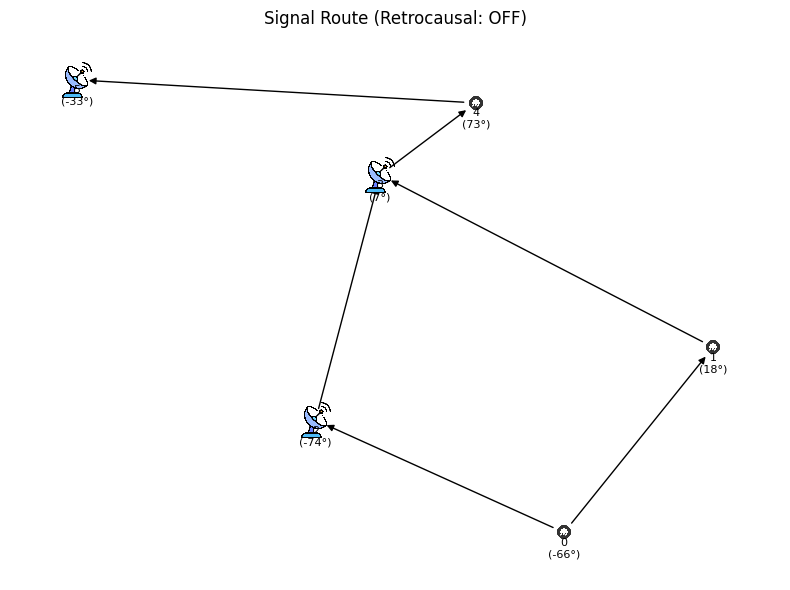

Step 0: Action=0, Obs=[0.11310209 1.        ], Reward=-1.0, Info={}

Final History:
From Node 0 took Action 1 into Weather storm


In [25]:
# Create the environment
env = SignalRouteEnv()

# Reset to start
obs = env.reset()
print("Initial Observation:", obs)

done = False
step = 0

while not done:
    env.render()  # Optional: show current state
    
    # Random action (for now)
    valid_actions = len(list(env.graph.neighbors(env.state)))
    action = random.randint(0, valid_actions - 1)
    
    obs, reward, done, info = env.step(action)
    print(f"Step {step}: Action={action}, Obs={obs}, Reward={reward}, Info={info}")
    step += 1
    time.sleep(0.5)

print("\nFinal History:")
for s, a, w in env.history:
    print(f"From Node {s} took Action {a} into Weather {w}")
